# # Aplicación de Python para procesamiento de imágenes DICOM

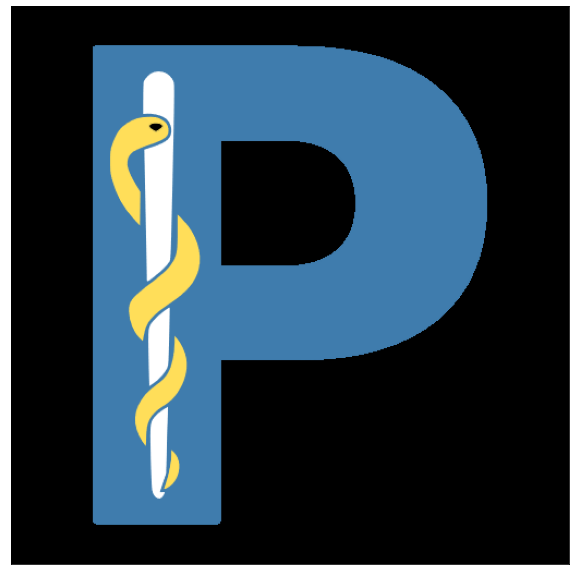

In [2]:
# Cabrera, Rafael: rafaelcabrera@unc.edu.ar
# Rusconi Lagarrigue, Ana Beatriz: anarusconi.2824@gmail.com

# En este trabajo se implementan ciertos códigos para poder manipular imágenes en formato DICOM, desde la importación hasta
# su procesado, donde es necesario cambiar el formato a JPG para poder utilizar las herramientas que tenemos a disposición.

# Procesamos la imágen para poder detectar bordes y contornos de acuerdo a nuestras necesidades. Para esto necesitamos varias 
# librerías tales como numpy, para poder tratar la imágen como una matriz de datos, Open CV, que contiene varias funciones, y 
# matplotlib que nos permitirá una correcta visualización de las imágenes.


import cv2
import numpy as np
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(10, 15)

PY=cv2.imread('pydicom_flat_black.png')
imgcolorPY=cv2.cvtColor(PY,cv2.COLOR_BGR2RGB)
plt.imshow(imgcolorPY), plt.xticks([]), plt.yticks([])
plt.show()

In [5]:
#Importo las librerías necesarias
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import os
import glob

%matplotlib inline

import pandas as pd
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

#cargo la carpeta donde guardé las imágenes DICOM. Son imágenes de resonancia magnética (RMI) de uan cabeza de una mujer adulta.
INPUT_FOLDER = 'C:/Users/user/Trabajo final MLIP 2019/dicom_files2'
patients =  os.listdir(INPUT_FOLDER)
patients.sort()

In [6]:
# Pydicom no es un servidor DICOM, y no es principalmente un visor de imágenes. 
# Está designado para manipular datos en archivos DICOM con lenguaje python.

from pydicom.data import get_testdata_files
file = get_testdata_files("rtplan.dcm")[0]
d = pydicom.dcmread(file)  # plan dataset

print('Nombre del Paciente_' , d.PatientName)

d.dir("setup")   # obtiene una lista de etiquetas con "setup" en algún lugar del nombre
print(d.PatientSetupSequence[0])
d.PatientSetupSequence[0].PatientPosition = "HFP"
d.save_as("rtplan2.dcm")
print(d)

Nombre del Paciente_ Last^First^mid^pre
(0018, 5100) Patient Position                    CS: 'HFS'
(300a, 0182) Patient Setup Number                IS: "1"
(300a, 01b2) Setup Technique Description         ST: ''
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 156
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: RT Plan Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.999.999.99.9.9999.9999.20030903150023
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.888.888.88.8.8.8
-------------------------------------------------
(0008, 0012) Instance Creation Date              DA: '20030903'
(0008, 0013) Instance Creation Time              TM: '150031'
(0008, 0016) SOP Class UID                       UI: RT Plan Storage
(0008, 0018) SOP Instance UID                    UI: 1

In [7]:
lstFilesDCM = []   # creo una lista vacía y voy agreagando los archivos DICOM en la lista
def load_scan2(path):
    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            if ".dcm" in filename.lower():  
                lstFilesDCM.append(os.path.join(dirName, filename))
    return lstFilesDCM

first_patient = load_scan2(INPUT_FOLDER)
print(lstFilesDCM)  #para visualizar la lista

['C:/Users/user/Trabajo final MLIP 2019/dicom_files2\\vhf.1726.dcm', 'C:/Users/user/Trabajo final MLIP 2019/dicom_files2\\vhf.1727.dcm', 'C:/Users/user/Trabajo final MLIP 2019/dicom_files2\\vhf.1728.dcm', 'C:/Users/user/Trabajo final MLIP 2019/dicom_files2\\vhf.1729.dcm', 'C:/Users/user/Trabajo final MLIP 2019/dicom_files2\\vhf.1730.dcm', 'C:/Users/user/Trabajo final MLIP 2019/dicom_files2\\vhf.1731.dcm', 'C:/Users/user/Trabajo final MLIP 2019/dicom_files2\\vhf.1732.dcm', 'C:/Users/user/Trabajo final MLIP 2019/dicom_files2\\vhf.1733.dcm', 'C:/Users/user/Trabajo final MLIP 2019/dicom_files2\\vhf.1734.dcm']


In [8]:
print (lstFilesDCM[0]) #visualizo el primer elemento de la lista

RefDs = pydicom.read_file(lstFilesDCM[0]) #leo el primer elemento
print (RefDs.Columns)
# Cargo las dimensiones basadas en el numnero de filas, columnas,y cortes(a lo largo del eje z)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# Cargo el esácio entre los datos (en mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))


x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

C:/Users/user/Trabajo final MLIP 2019/dicom_files2\vhf.1726.dcm
512


In [9]:
# El arreglo está dimensionado en 'ConstPixelDims'

ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# Bucle a través de todos los archivos DICOM
for filenameDCM in lstFilesDCM:
    # Leo el archivo
    ds = pydicom.read_file(filenameDCM)
    # Almaceno los datos de imágen sin procesar
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array

In [10]:
RefDs.pixel_array.dtype

dtype('int16')

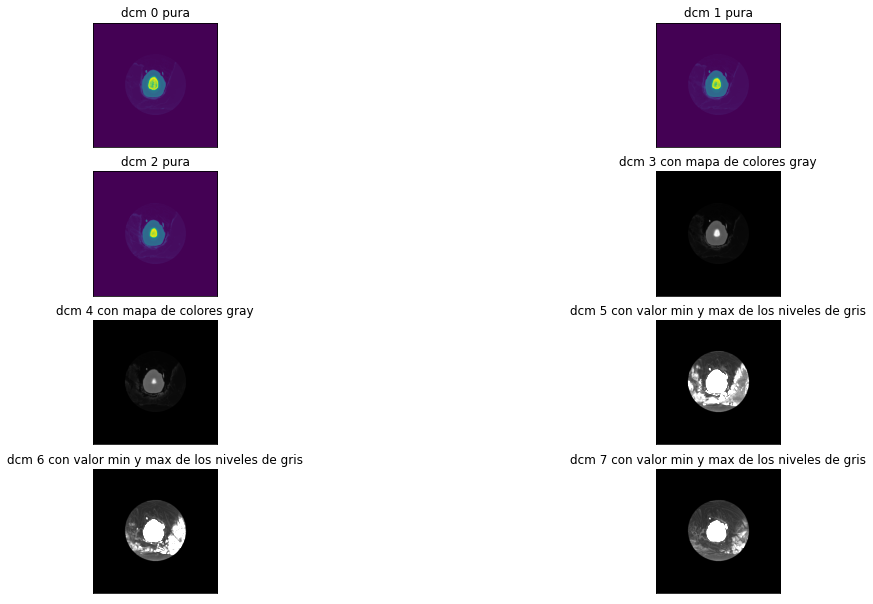

In [11]:
# Mostramos cada imágen de la lista en formato DICOM

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.subplot(4,2,1),plt.imshow((ArrayDicom[:, :, 0]))#,cmap = 'gray')
plt.title('dcm 0 pura'), plt.xticks([]), plt.yticks([])
plt.subplot(4,2,2),plt.imshow((ArrayDicom[:, :, 1]))#,cmap = 'gray')
plt.title('dcm 1 pura'), plt.xticks([]), plt.yticks([])
plt.subplot(4,2,3),plt.imshow((ArrayDicom[:, :, 2]))#,cmap = 'gray')
plt.title('dcm 2 pura'), plt.xticks([]), plt.yticks([])
plt.subplot(4,2,4),plt.imshow((ArrayDicom[:, :, 3]),cmap = 'gray')
plt.title('dcm 3 con mapa de colores gray'), plt.xticks([]), plt.yticks([])
plt.subplot(4,2,5),plt.imshow((ArrayDicom[:, :, 4]),cmap = 'gray')
plt.title('dcm 4 con mapa de colores gray'), plt.xticks([]), plt.yticks([])
plt.subplot(4,2,6),plt.imshow((ArrayDicom[:, :, 5]),cmap = 'gray', vmin=0,vmax=255)
plt.title('dcm 5 con valor min y max de los niveles de gris'), plt.xticks([]), plt.yticks([])
plt.subplot(4,2,7),plt.imshow((ArrayDicom[:, :, 6]),cmap = 'gray', vmin=0,vmax=255)
plt.title('dcm 6 con valor min y max de los niveles de gris'), plt.xticks([]), plt.yticks([])
plt.subplot(4,2,8),plt.imshow((ArrayDicom[:, :, 7]),cmap = 'gray', vmin=0,vmax=255)
plt.title('dcm 7 con valor min y max de los niveles de gris'), plt.xticks([]), plt.yticks([])



plt.show()

In [30]:
#Convierto los archivos DICOM en formato JPG para poder procesarla

#Hacer esto true si quiero en formato PNG
PNG = False

# Especifico la rurta de la carpeta de archivos .dcm
folder_path = "C:/Users/user/Trabajo final MLIP 2019/dicom_files2"

# Especifico la ruta de la carpeta donde se cargan archivos JPG/PNG 
jpg_folder_path = "C:/Users/user/Trabajo final MLIP 2019/notebook"

images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    ds = pydicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    if PNG == False:
        image = image.replace('.dcm', '.jpg')
    else:
        image = image.replace('.dcm', '.png')
    cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
    if n % 50 == 0:
        print('{} image converted'.format(n))

0 image converted


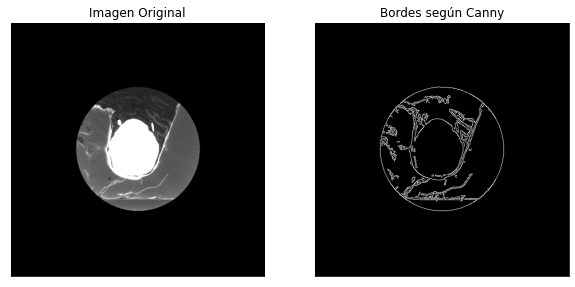

In [31]:
#Trabajo con la imágen y aplico un detector de bordes canny 
#Bordes = cv2.Canny(img,umbrali,umbrals)

import cv2
import numpy as np
from matplotlib import pyplot as plt


img = cv2.imread(r"notebook/vhf.1726.jpg",0)

edges = cv2.Canny(img,40,150)

fig = plt.gcf()
fig.set_size_inches(10, 15)

plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Imagen Original'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.title('Bordes según Canny'), plt.xticks([]), plt.yticks([])
 
plt.show()
img = cv2.imread('puzzle.png',0)

Ingrese umbral inferior 1: 140
Ingrese umbral superior 1: 240
Ingrese umbral inferior 2: 190
Ingrese umbral superior 2: 210


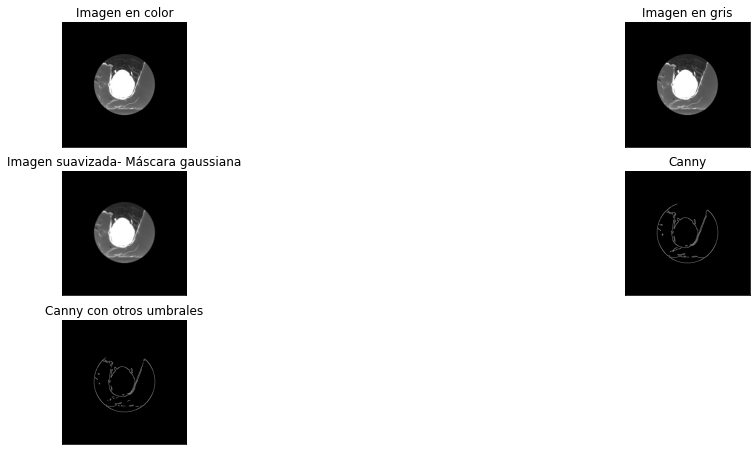

In [33]:
#Trabajo con la imágen y detecto contornos
#Primero, convierto la imágen a niveles de grises, ya que el detector de bordes canny necesita de esta conversión. Además 
#se elimina el coste computacional.
#Luego elimino el ruido de la imágen con una función gaussiana. Ésta función consiste en una convolución de la imágen con una 
# máscara o kernel específico, de preferencia impar (5,5),
#dándole más importancia al píxel central que a los píxeles que están alrededor de éste.
#El resultado es una imágen estilo desenfocada.
#Aplico el detector de bordes canny
#Aplico el detector de contornos identificando pixeles externos

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

#cargo la imágen

imgcolor = cv2.imread(r"notebook/vhf.1726.jpg")
imgcolorRGB=cv2.cvtColor(imgcolor,cv2.COLOR_BGR2RGB)

# caambio de BGR a RGB 
imggris=cv2.cvtColor(imgcolor,cv2.COLOR_BGR2GRAY)

imggaussiana=cv2.GaussianBlur(imggris,(5,5),0) #0 indica la desviación estándar de la función, y que se encarga ella misma de 
#de aplicar esa desviación

umbrali=int(input('Ingrese umbral inferior 1: '))
umbrals=int(input('Ingrese umbral superior 1: '))

imgcanny = cv2.Canny(imggaussiana, umbrali,umbrals)

plt.subplot(4,2,1), plt.imshow(imgcolorRGB)
plt.title('Imagen en color'), plt.xticks([]), plt.yticks([])

plt.subplot(4,2,2), plt.imshow(imggris,cmap='gray')
plt.title('Imagen en gris'), plt.xticks([]), plt.yticks([])

plt.subplot(4,2,3), plt.imshow(imggaussiana,cmap='gray')
plt.title('Imagen suavizada- Máscara gaussiana'), plt.xticks([]), plt.yticks([])

plt.subplot(4,2,4), plt.imshow(imgcanny,cmap='gray')
plt.title('Canny'), plt.xticks([]), plt.yticks([])

umbralii=int(input('Ingrese umbral inferior 2: '))
umbralss=int(input('Ingrese umbral superior 2: '))

imgcannyy = cv2.Canny(imggaussiana, umbralii,umbralss)

plt.subplot(4,2,5), plt.imshow(imgcannyy,cmap='gray')
plt.title('Canny con otros umbrales'), plt.xticks([]), plt.yticks([])

plt.show()

Encontró  30  objetos con umbrales suficientemente espaciados (40/200)
Con otros umbrales más cercanos entre sí encontró  55  objetos


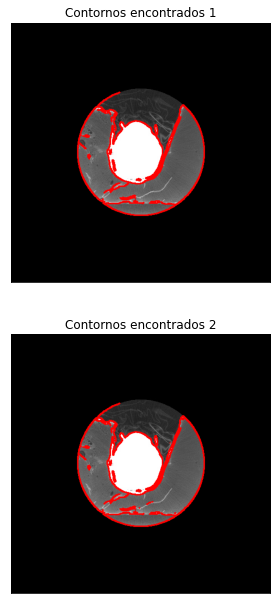

In [34]:
#Buscamos contornos
#cv2.findContours(arg1,arg2,arg3)
#arg1 es la imagen
#arg2 es el tipo de contorno. Pedimos solo el contorno externo #cv2.RETR_EXTERNAL
#arg3 es el método usado para enlazar
#Utilizaremos un método simple, eliminando píxeles redundantes cv2.CHAIN_APPROX_SIMPL


#Buscamos contornos para umbrales en canny suficientemente alejados
(contornos, hierarc) = cv2.findContours(imgcanny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print("Encontró ",len(contornos)," objetos con umbrales suficientemente espaciados (40/200)")

cv2.drawContours(imgcolor,contornos,-1,(0,0,255), 2)

imgcolorRGB=cv2.cvtColor(imgcolor,cv2.COLOR_BGR2RGB)


#Buscamos contornos para umbrales en canny más cercanos entre sí
(contornos, hierarc) = cv2.findContours(imgcannyy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print("Con otros umbrales más cercanos entre sí encontró ",len(contornos)," objetos")

cv2.drawContours(imgcolor,contornos,-1,(0,0,255), 2)

imgcolorRGBB=cv2.cvtColor(imgcolor,cv2.COLOR_BGR2RGB)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.subplot(2,1,1), plt.imshow(imgcolorRGB,cmap='gray')
plt.title('Contornos encontrados 1'), plt.xticks([]), plt.yticks([])

plt.subplot(2,1,2), plt.imshow(imgcolorRGBB,cmap='gray')
plt.title('Contornos encontrados 2'), plt.xticks([]), plt.yticks([])

plt.show()


#Con dos umbrales en canny suficientemente distanciados(40/200), se detectan más bordes, 
#y es más fácil detectar contornos más fieles.

Ingrese umbral: 250


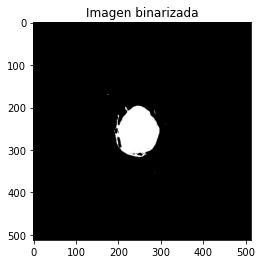

Ingrese umbral inferior: 50
Ingrese umbral superior: 240


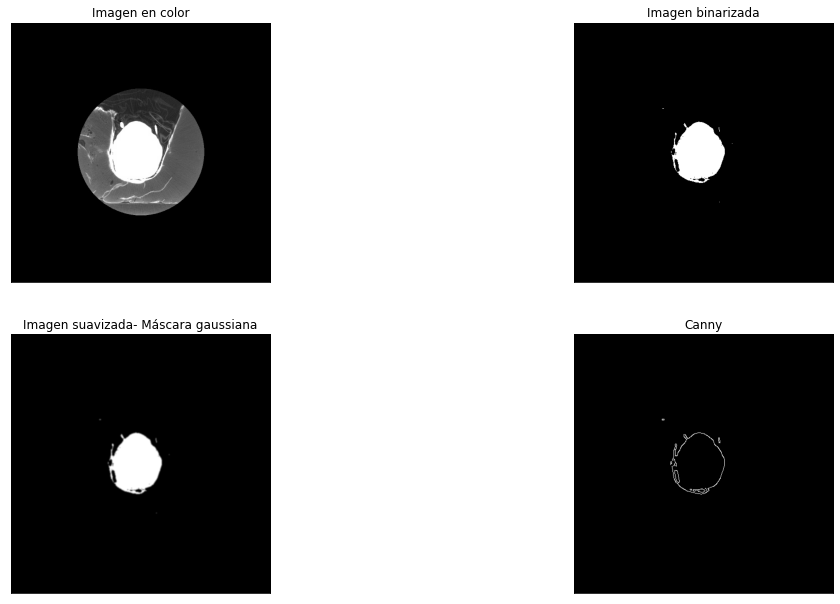

In [35]:
#En los siguientes códigos se prueba hacer lo mismo que en el código anterior, excepto que se plantea 
#realizar una binarización de la imágen previo a la detección de bordes, y ver qué ocurre con la detección de contornos.


imi = cv2.imread(r"notebook/vhf.1726.jpg") 
im=cv2.cvtColor(imgcolor,cv2.COLOR_BGR2GRAY)
umbral=int(input('Ingrese umbral: '))
ret1,binaria1 = cv2.threshold(im,umbral,1000,cv2.THRESH_BINARY)

plt.imshow(binaria1, cmap='gray'), plt.title("Imagen binarizada")
plt.show()

imggausiana=cv2.GaussianBlur(binaria1,(5,5),0) #0 indica la desviación estándar de la función, y que se encarga ella misma de 
#de aplicar esa desviación

umbralin=int(input('Ingrese umbral inferior: '))
umbralsu=int(input('Ingrese umbral superior: '))

imggcanny = cv2.Canny(imggausiana, umbralin,umbralsu)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5) 

plt.subplot(2,2,1), plt.imshow(imi)
plt.title('Imagen en color'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,2), plt.imshow(binaria1,cmap='gray')
plt.title('Imagen binarizada'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,3), plt.imshow(imggausiana,cmap='gray')
plt.title('Imagen suavizada- Máscara gaussiana'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,4), plt.imshow(imggcanny,cmap='gray')
plt.title('Canny'), plt.xticks([]), plt.yticks([])


plt.show()

#Con un umbral suficientemente alto (250) la imágen binarizada tiene un alto contraste, y los bordes que se encuentran 
#son menos redundantes

Encontró  8  objetos


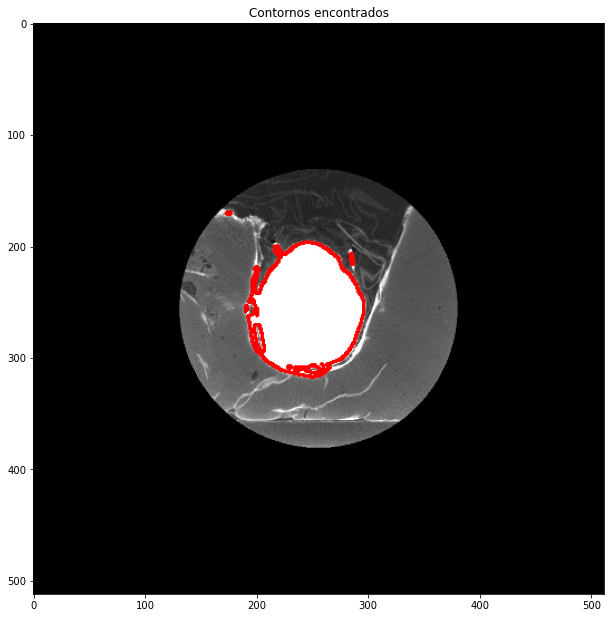

In [36]:
(contornos, hierarc) = cv2.findContours(imggcanny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print("Encontró ",len(contornos)," objetos")

cv2.drawContours(imi,contornos,-1,(0,0,255), 2)

imgcolorRGB=cv2.cvtColor(imi,cv2.COLOR_BGR2RGB)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.imshow(imgcolorRGB),plt.title('Contornos encontrados')
plt.show()

#Se puede observar que al aplicar la binarización previo a buscar los contornos, se obtienen contornos no redundantes,
#es decir, se encuentran aquellos que constituyen un alto contraste dentro de la imágen

In [37]:
#img= cv2.imread('vhf.1726.jpg') 
#im=cv2.cvtColor(imgcolor,cv2.COLOR_BGR2GRAY)